In [1]:
from __future__ import print_function
import argparse
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
from models.binarized_modules import  Binarize,HingeLoss
import matplotlib.pyplot as plt

In [2]:
class BNN_SW(nn.Module):
    
    def __init__(self, in_features = 28*28, HL_1=100, HL_2=100, HL_3=100, out_features=10,dropout = 0.5):
        super(BNN_SW, self).__init__()
        self.in_features = in_features
        self.fc1 = BinarizeLinear(in_features, HL_1, bias = False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(HL_1)
        self.fc2 = BinarizeLinear(HL_1, HL_2, bias = False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(HL_2)
        self.fc3 = BinarizeLinear(HL_2, HL_3, bias = False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(HL_3)
        self.fc4 = BinarizeLinear(HL_3, out_features, bias = False)
        self.drop=nn.Dropout(dropout)
        self.logsoftmax=nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, self.in_features)
        x = self.fc1(x)    
        x = self.bn1(x)    
        x = self.htanh1(x) 
        x = self.fc2(x)    
        x = self.bn2(x)    
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.drop(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        return self.logsoftmax(x)

class BNN_HW(nn.Module):

    def __init__(self, in_features = 28*28, HL_1=100, HL_2=100, HL_3=100, out_features=10):
        super(BNN_HW, self).__init__()
        self.in_features = in_features
        self.fc1 = BinarizeLinear(in_features, HL_1, bias = False)
        self.fc2 = BinarizeLinear(HL_1, HL_2, bias = False)
        self.fc3 = BinarizeLinear(HL_2, HL_3, bias = False)
        self.fc4 = BinarizeLinear(HL_3, out_features, bias = False)

    def forward(self, x):
        x = x.view(-1, self.in_features)
        x = self.fc1(x)
        x = my_sign(x)
        x = self.fc2(x)
        x = my_sign(x)
        x = self.fc3(x)
        x = my_sign(x)
        x = self.fc4(x)
        return x


In [3]:
def train(epoch,model_hw,space_idx,learning_rate):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_hw.parameters(), learning_rate) # Adam algorithm to optimize change of learning_rate


    model_hw.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model_hw(data)
        #print("shape is ",data.shape)
        loss = criterion(output, target)

        if epoch%40==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        optimizer.zero_grad()
        loss.backward()
        for p in list(model_hw.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        for p in list(model_hw.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))

            
  

In [4]:
def my_sign(a):
    
    a_buff = torch.empty(a.shape)
    for idx, element in enumerate(a):
        for idy, sub_element in enumerate(element):
            if(sub_element >= 0):
                a_buff[idx][idy] = 1
            else:
                a_buff[idx][idy] = -1
            
    return a_buff


def test_sw(model):
    
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
       
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    
    return 100. * correct / len(test_loader.dataset)


def test_hw(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            #print(data)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    
    return 100. * correct / len(test_loader.dataset)

In [5]:
IMAGE_SIZE = 28

class ThresholdTransform(object):
    def __init__(self, thr_255):
        self.thr = thr_255   # input threshold for [0..255] gray level, convert to [0..1]

    def __call__(self, x):
        x[x >= 0] = 1
        x[x <= 0] = 0      
        return x  
    
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                ThresholdTransform(thr_255=0)])

In [9]:
res = []

HL_1 = [32, 64]
HL_2 = [32]
HL_3 = [32]
LR = [0.003]
DO = [0.5]
EPOCH_N = [1,5]
BATCH_N = [64]

search_space = []
import itertools
#search_space[   0     1       2    3  4     5       6  ]
#search_space[layer1,layer2,layer3,LR,DO,EPOCH_N,BATCH_N]
for r in itertools.product(HL_1,HL_2,HL_3,LR,DO,EPOCH_N,BATCH_N): search_space.append((r[0],r[1],r[2],r[3],r[4],r[5],r[6]))

print(search_space)
# Outer loop with the search space
for space_idx, space in enumerate(search_space):
    
    model_sw = BNN_SW(in_features = IMAGE_SIZE*IMAGE_SIZE,
                      HL_1 = space[0],
                      HL_2 = space[1],
                      HL_3 = space[2],
                      dropout = space[4])
    
    model_hw = BNN_HW(in_features = IMAGE_SIZE*IMAGE_SIZE,
                      HL_1 = space[0],
                      HL_2 = space[1],
                      HL_3 = space[2])

    train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=space[6], shuffle=True)
    test_loader = DataLoader(test_data)

    # Inner loop for epochs 
    for epoch in range(1, space[5] + 1):
        train(epoch,model_sw,space_idx,space[3])
    
    accuracy_sw = test_sw(model_sw)
    
    model_hw.fc1.weight = model_sw.fc1.weight
    model_hw.fc2.weight = model_sw.fc2.weight
    model_hw.fc3.weight = model_sw.fc3.weight
    model_hw.fc4.weight = model_sw.fc4.weight
       
    accuracy_hw = test_hw(model_hw)
    
    print(space,'space {}/{}'.format(space_idx,len(search_space)-1),"HW_acc:",accuracy_hw,"SW_acc:",accuracy_sw)
    res.append(('H1{}-H2{}-H3{}-LR{}-DO{}-EPOCH{}-BATCH{}'.format(space[0],space[1],space[2],space[3],space[4],space[5],space[6]),accuracy_sw.item(),accuracy_hw.item()))
    
    del model_sw
    del model_hw 

[(32, 32, 32, 0.003, 0.5, 1, 64), (32, 32, 32, 0.003, 0.5, 5, 64), (64, 32, 32, 0.003, 0.5, 1, 64), (64, 32, 32, 0.003, 0.5, 5, 64)]


/var/folders/8f/j0yzvf055y7c23h6ltl5b3pr0000gn/T/ipykernel_83649/1917398667.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


(32, 32, 32, 0.003, 0.5, 1, 64) space 0/3 HW_acc: tensor(72.5900) SW_acc: tensor(81.5200)
(32, 32, 32, 0.003, 0.5, 5, 64) space 1/3 HW_acc: tensor(61.1400) SW_acc: tensor(86.7300)
(64, 32, 32, 0.003, 0.5, 1, 64) space 2/3 HW_acc: tensor(67.1300) SW_acc: tensor(85.3600)
(64, 32, 32, 0.003, 0.5, 5, 64) space 3/3 HW_acc: tensor(73.5100) SW_acc: tensor(90.3000)


4


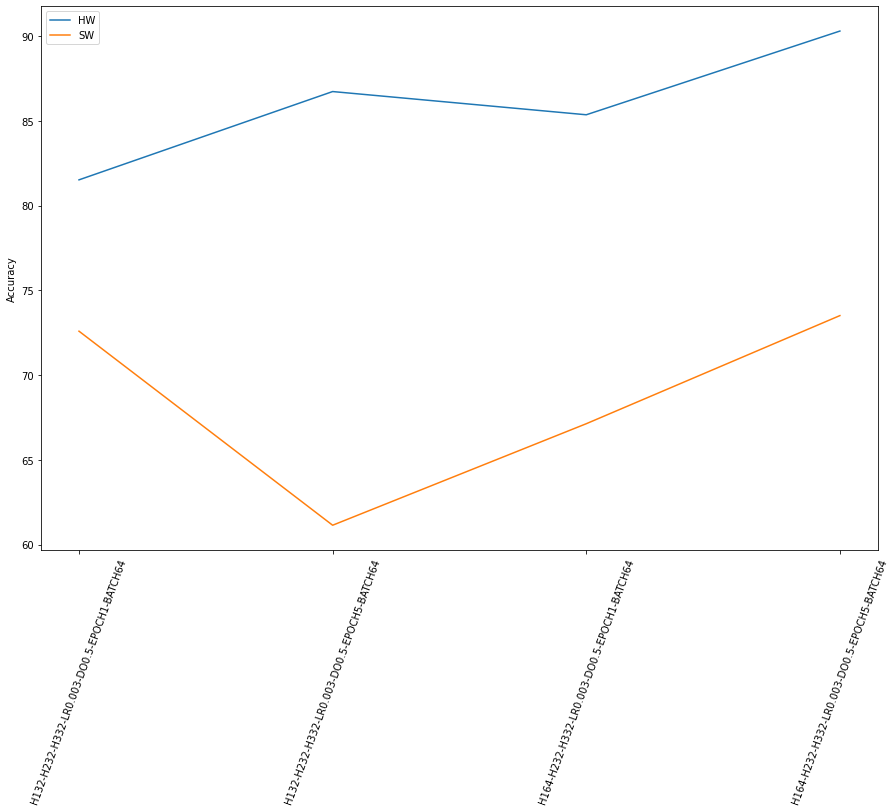

In [15]:
#Script to save file with results in csv and an image result 

res = np.array(res,dtype=object)
np.savetxt("optimize.csv", res, fmt = '%s,%f,%f', delimiter = ",")
print(len(res))
fig = plt.figure(figsize=(15,10))
x = np.arange(len(res))
plt.plot(x,res[:,1],label="HW")
plt.plot(x,res[:,2],label="SW")
my_xticks = res[:,0]
plt.ylabel("Accuracy")
plt.xticks(x, my_xticks)
plt.legend(loc="best")
degrees = 70
plt.xticks(rotation=degrees)
plt.savefig("optimize.jpg",bbox_inches='tight', dpi=150)


In [ ]:
res

In [ ]:
res = np.array(res)
res[:,0]

In [ ]:
TRAIN_LOSS = []
TRAIN_LOSS.append((1,2,3))
TRAIN_LOSS.append((5,5,5))
TRAIN_LOSS

In [ ]:
from tqdm import tqdm
